In [18]:
# Important libraries
import re
from collections import Counter

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [19]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igame\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\igame\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\igame\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [21]:
reviews = pd.read_csv("BA_reviews.csv", index_col=0)
reviews.head()

,reviews
0,"Not Verified | On March 1st, I flew from Ber..."
1,Not Verified | The WORST customer experience! ...
2,Not Verified | Had to cancel my flight month...
3,✅ Trip Verified | Flight cancelled with no rea...
4,✅ Trip Verified | This is a route I fly regula...


In [22]:
# Main cleaning function
def preprocess_review_text(df, review_columns):
    
    # Remove special characters
    def clean_special(text):
        return re.sub(r"Not Verified\s*\|\s*|✅ Trip Verified\s*\|\s*", "", text)
    df[review_columns] = df[review_columns].apply(clean_special)
    
    # Convert to lowercase
    df[review_columns] = df[review_columns].str.lower()
    
    # Remove punctuations
    df[review_columns] = df[review_columns].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    df[review_columns] = df[review_columns].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

    
    return df

In [23]:
# Preprocessing data
cleaned_reviews = preprocess_review_text(reviews, review_columns='reviews')
cleaned_reviews.head()

,reviews
0,march 1st flew berlin são paulo ba encountered...
1,worst customer experience british airways ba e...
2,cancel flight months advance due change schedu...
3,flight cancelled reason given less 24 h depart...
4,route fly regularly used first class security ...


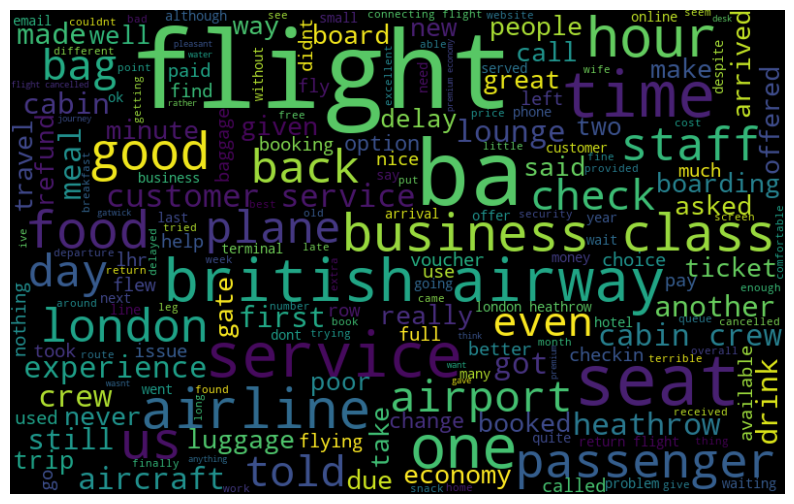

In [24]:
# Creating word cloud for windows
all_words = ' '.join([text for text in cleaned_reviews['reviews']])
word_cloud = WordCloud(width=800, height=500, random_state=42, max_font_size = 110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.savefig("WordCloud.png")
plt.show()

In [25]:
# Figuring out most common words

words = cleaned_reviews['reviews'].str.split()
words = words.values.tolist()
words = [word for sublit in words for word in sublit]

most_common_words = Counter(words).most_common(20)
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
common_words_df

,Word,Frequency
0,flight,1954
1,ba,1225
2,service,736
3,time,541
4,london,505
5,seat,452
6,crew,445
7,class,443
8,british,436
9,food,430


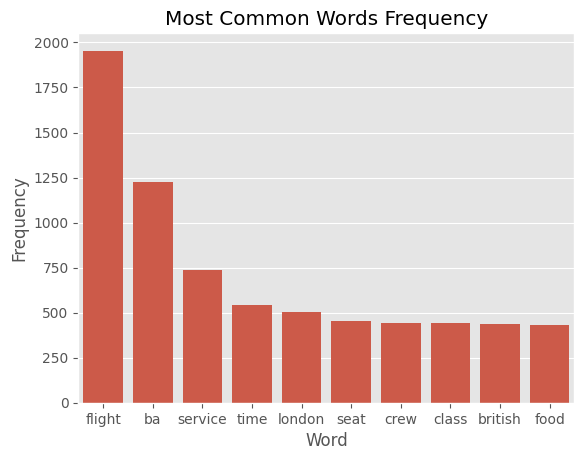

In [26]:
# bar chart showing most_common words

sns.barplot(
    x = common_words_df['Word'].head(10),
    y = common_words_df['Frequency'].head(10)
)
plt.title("Most Common Words Frequency")
plt.savefig("Common_words.png");

In [27]:
# Getting sentiments
def get_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_score = sia.polarity_scores(text)
    if sentiment_score['compound'] > 0.05:
        return 'Positive'
    elif sentiment_score['compound'] < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

cleaned_reviews['sentiment'] = cleaned_reviews['reviews'].apply(get_sentiment)
cleaned_reviews.head()

,reviews,sentiment
0,march 1st flew berlin são paulo ba encountered...,Negative
1,worst customer experience british airways ba e...,Negative
2,cancel flight months advance due change schedu...,Negative
3,flight cancelled reason given less 24 h depart...,Negative
4,route fly regularly used first class security ...,Positive


In [28]:
# Number of positive and negative sentiments

cleaned_reviews['sentiment'].value_counts()

sentiment
Positive    547
Negative    435
Neutral      18
Name: count, dtype: int64

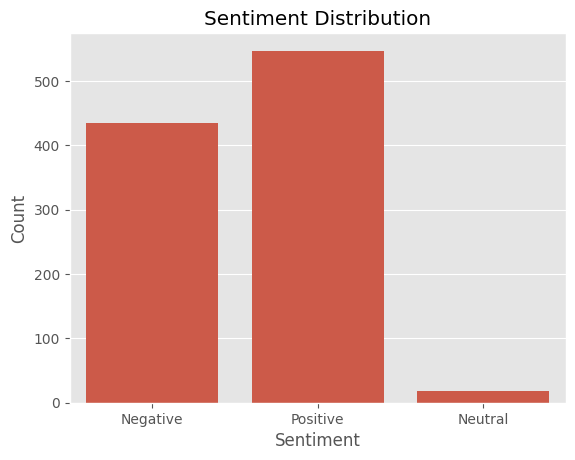

In [29]:
import seaborn as sns

sns.countplot(x='sentiment', data=cleaned_reviews)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.savefig("Count_sent.png")
plt.show()


In [30]:
cleaned_reviews['sentiment'].value_counts(normalize = True) * 100

sentiment
Positive    54.7
Negative    43.5
Neutral      1.8
Name: proportion, dtype: float64

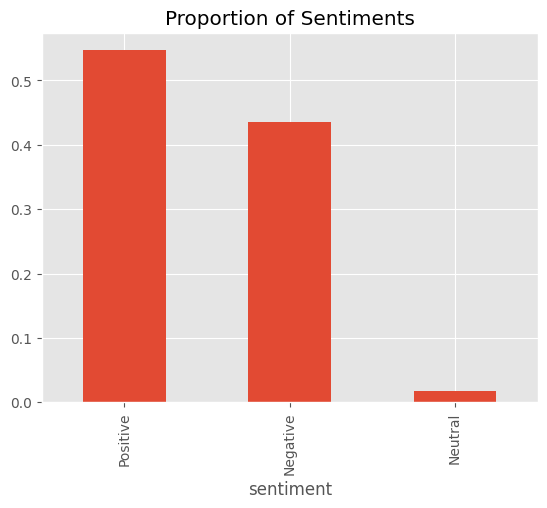

In [31]:
# Plotting a bar chart of number of sentiments

cleaned_reviews['sentiment'].value_counts(normalize = True).plot(kind="bar")
plt.title("Proportion of Sentiments")
plt.savefig("Sentiment_Proprtion.png");

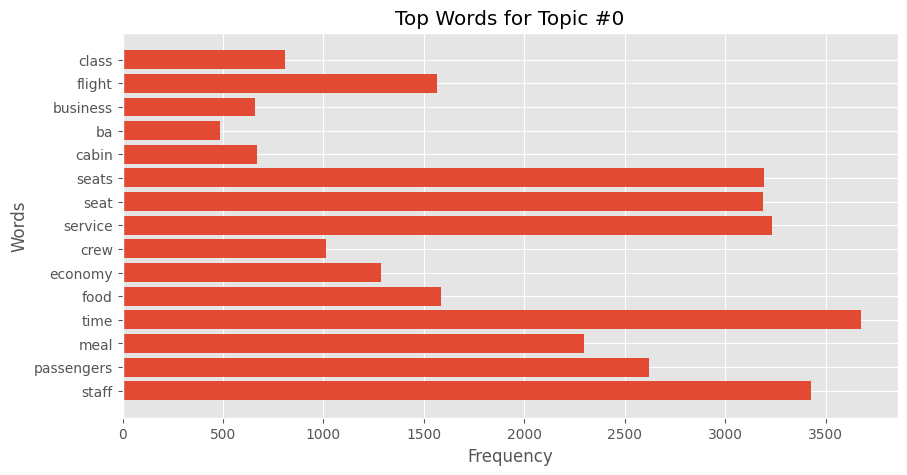

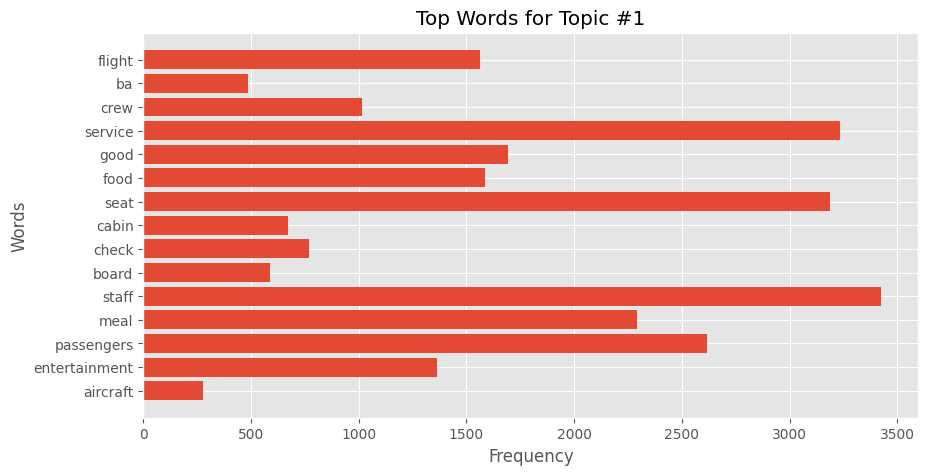

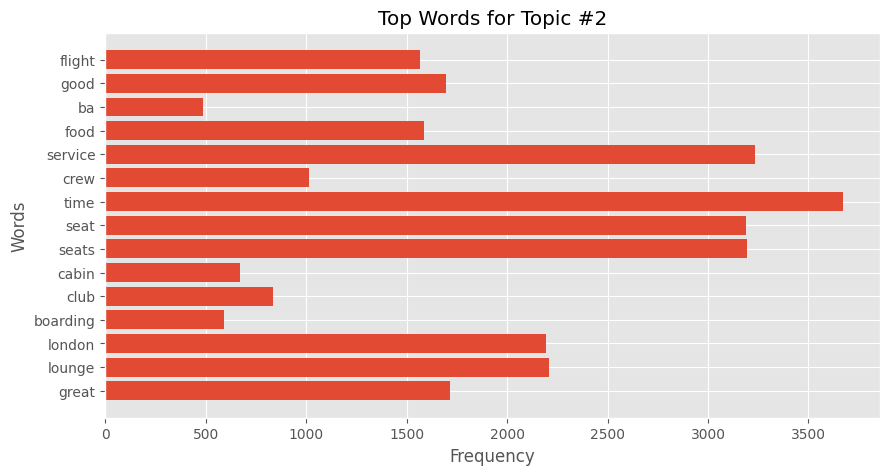

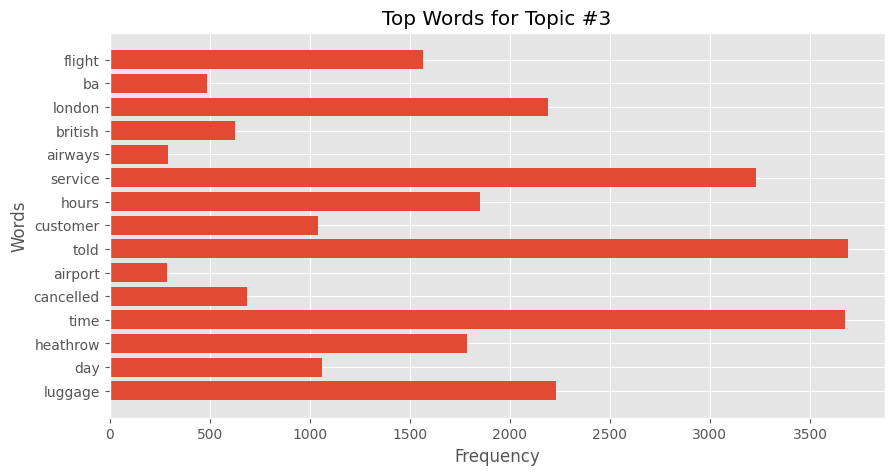

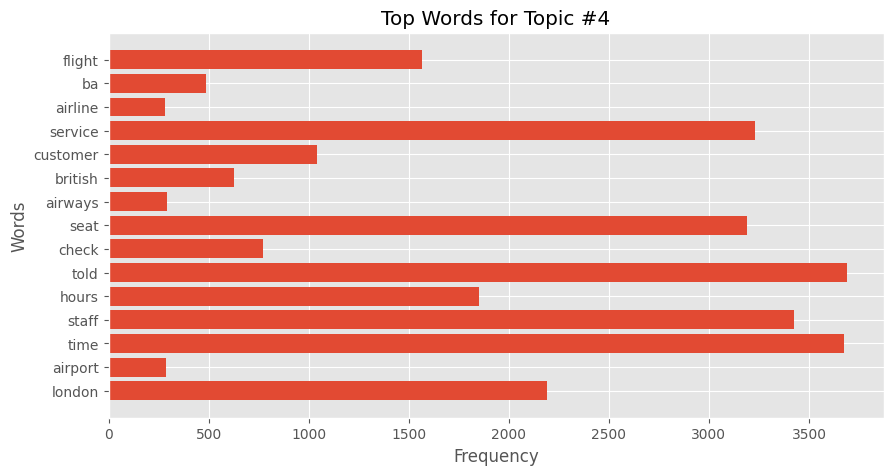

In [32]:
# Topic modeling
def plot_lda_topics(cleaned_df, review_column, n_topics=5):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(cleaned_df[review_column])

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)

    for index, topic in enumerate(lda.components_):
        topic_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]]
        plt.figure(figsize=(10, 5))
        plt.barh(topic_words, topic.argsort()[-15:])
        plt.title(f'Top Words for Topic #{index}')
        plt.xlabel("Frequency")
        plt.ylabel("Words")
        plt.savefig(f'topic_{index}.png')

plot_lda_topics(cleaned_reviews, 'reviews')



In [37]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(cleaned_reviews['reviews'])

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(dtm)

for index, topic in enumerate(LDA.components_):
    print(f'Top 15 words for Topic #{index}')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

Top 15 words for Topic #0
['staff', 'passengers', 'meal', 'time', 'food', 'economy', 'crew', 'service', 'seat', 'seats', 'cabin', 'ba', 'business', 'flight', 'class']


Top 15 words for Topic #1
['aircraft', 'entertainment', 'passengers', 'meal', 'staff', 'board', 'check', 'cabin', 'seat', 'food', 'good', 'service', 'crew', 'ba', 'flight']


Top 15 words for Topic #2
['great', 'lounge', 'london', 'boarding', 'club', 'cabin', 'seats', 'seat', 'time', 'crew', 'service', 'food', 'ba', 'good', 'flight']


Top 15 words for Topic #3
['luggage', 'day', 'heathrow', 'time', 'cancelled', 'airport', 'told', 'customer', 'hours', 'service', 'airways', 'british', 'london', 'ba', 'flight']


Top 15 words for Topic #4
['london', 'airport', 'time', 'staff', 'hours', 'told', 'check', 'seat', 'airways', 'british', 'customer', 'service', 'airline', 'ba', 'flight']


